In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

- サンプルデータを使用\
物理・化学・統計の得点により数学の得点を予測\
1列目：物理(特徴量 X)\
2列目：化学(特徴量 X)\
3列目：統計(特徴量 X)\
4列目：数学(目的変数 y)

In [2]:
data = np.loadtxt('lr_sample.csv', delimiter=',', skiprows=1)

In [3]:
data.shape

(99, 4)

In [4]:
data

array([[ 64.,  67.,  69.,  68.],
       [ 74.,  74.,  63.,  67.],
       [ 60.,  59.,  55.,  57.],
       [ 84.,  88.,  89.,  91.],
       [ 80.,  88.,  78.,  82.],
       [ 75.,  68.,  68.,  63.],
       [ 66.,  59.,  55.,  65.],
       [ 77.,  71.,  66.,  73.],
       [ 70.,  71.,  60.,  67.],
       [ 89.,  84.,  80.,  85.],
       [ 73.,  76.,  69.,  82.],
       [ 78.,  74.,  63.,  67.],
       [ 67.,  63.,  67.,  57.],
       [ 80.,  81.,  83.,  74.],
       [ 72.,  75.,  73.,  83.],
       [ 68.,  63.,  76.,  71.],
       [ 81.,  89.,  80.,  85.],
       [ 64.,  66.,  59.,  69.],
       [ 79.,  81.,  79.,  87.],
       [ 70.,  76.,  69.,  71.],
       [ 76.,  80.,  68.,  80.],
       [ 71.,  64.,  75.,  66.],
       [ 81.,  77.,  84.,  73.],
       [ 85.,  83.,  87.,  90.],
       [ 61.,  67.,  70.,  61.],
       [ 74.,  71.,  75.,  73.],
       [ 85.,  82.,  78.,  84.],
       [ 60.,  60.,  57.,  52.],
       [ 83.,  88.,  80.,  92.],
       [ 85.,  80.,  76.,  87.],
       [ 8

In [5]:
X = data[:,:3].reshape(-1, 3)
y = data[:,3]

In [6]:
#正規化
def normalize_x_features(X):
    X_norm = np.zeros((X.shape[0], X.shape[1]))
    mean = np.zeros((1, X.shape[1]))
    std = np.zeros((1, X.shape[1]))
    for i in range(X.shape[1]):
        mean[:, i] = np.mean(X[:, i])
        std[:, i] = np.std(X[:, i])
        X_norm[:, i] = (X[:, i] - float(mean[:, i])) / float(std[:, i])
    return X_norm, mean, std

In [7]:
X_norm, mean, std = normalize_x_features(X)

In [8]:
X_norm[0:5, :]

array([[-1.28095057, -0.76202794, -0.45626449],
       [-0.10238081, -0.05223579, -1.002678  ],
       [-1.75237847, -1.57321897, -1.73122936],
       [ 1.07618895,  1.36734852,  1.36511391],
       [ 0.60476105,  1.36734852,  0.36335579]])

In [9]:
print(X_norm.mean())
print(X_norm.std())

1.4354398702224247e-16
1.0


- クラスの定義

In [10]:
class ScratchLinearRegression():
    """
    線形回帰のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    no_bias : bool
      バイアス項を入れない場合はTrue
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      パラメータ
    self.loss : 次の形のndarray, shape (self.iter,)
      訓練データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証データに対する損失の記録
    """
    def __init__(self, num_iter, lr, no_bias, verbose):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.no_bias = no_bias
        self.verbose = verbose
        # 損失を記録する配列を用意
        #self.coef_ = np.random.rand(X.shape[1]+1).reshape(-1, 1)
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)
        
    def _define_feature_variables(self, X):
        """
        特徴量Xの1列目が全て値1の列を結合
        """
        one = np.ones(X.shape[0]).reshape(-1, 1)
        X_ = np.concatenate((one, X), axis=1)

        return X_

    def _linear_hypothesis(self, X, theta):
        """
        線形の仮定関数を計算する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          訓練データ
        theta：回帰係数ベクトル(n_features)

        Returns
        -------
        y_hut
          次の形のndarray, shape (n_samples, 1)
          線形の仮定関数による推定結果
        """
        y_hut = np.dot(X, theta)
        
        return y_hut

    def _gradient_descent(self, X, y, theta):
        """
        パラメータtheta更新用のメソッド

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          訓練データ
        theta：回帰係数ベクトル(n_features)

        Returns
        -------
        theta：回帰係数ベクトル shape (n_features, 1)

        """
        y_hut = self._linear_hypothesis(X, theta)    

        theta -= np.transpose(np.dot(np.transpose(y_hut - y.reshape(-1, 1)), X)*
                              self.lr/len(X))

        return theta   

    def _compute_y_hut_by_updated_theta(self, X, theta):
        """
        更新したthetaによってy_hutを計算する関数

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          訓練データ
        theta：回帰係数ベクトル(n_features)

        Returns
        -------
        y_hut
          次の形のndarray, shape (n_samples, 1)
          線形の仮定関数による推定結果
        """
        y_hut = self._linear_hypothesis(X, theta)
        return y_hut

    def _cost_function(self, y_hut, y):
        """
        平均二乗誤差及びコスト関数による計算

        Parameters
        ----------
        y_hut : 次の形のndarray, shape (n_samples,)
          推定した値
        y : 次の形のndarray, shape (n_samples,)
          正解値

        Returns
        ----------
        J : numpy.float
          平均二乗誤差の半分
        """
        m = len(y)
        J = 0
        square_error = np.square(y_hut - y.reshape(-1, 1))
        mse = np.sum(square_error) / m
        J = mse / 2

        return J
    
    def fit(self, X, y, X_val=None, y_val=None):
        """
        線形回帰を学習する。
        検証データが入力された場合は、
        それに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        if self.no_bias is False:
            X = self._define_feature_variables(X)
            if not(X_val is None) and not(y_val is None):
                X_val = self._define_feature_variables(X_val)

        theta = np.random.rand(X.shape[1]).reshape(-1, 1)

        for i in range(self.iter):

            self.theta = self._gradient_descent(X, y, theta)

            y_hut = self._compute_y_hut_by_updated_theta(X, theta)

            self.loss[i] = self._cost_function(y_hut, y)

            if not(X_val is None) and not(y_val is None):
                y_val_hut = self._compute_y_hut_by_updated_theta(X_val, theta)
                self.val_loss[i] = self._cost_function(y_val_hut, y_val)

            if self.verbose:
                #verboseをTrueにした場合は学習過程を出力
                print("Training Data" + "*"*40)
                print("theta:{}".format(theta.T))
                print("loss in cost function:{}".format(self.loss[i]))
                if not(X_val is None) and not(y_val is None):
                    print("Validation Data" + "*"*40)
                    print("theta:{}".format(theta.T))
                    print("loss in cost function:{}".format(self.val_loss[i]))                    
            
    def predict(self, X):
        """
        線形回帰を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
        y_hut
            次の形のndarray, shape (n_samples, 1)
            線形回帰による推定結果
        """
        if self.no_bias is False:
            X = self._define_feature_variables(X)
            
        y_hut = self._linear_hypothesis(X, self.theta)

        return y_hut

### 【問題1】仮定関数
以下の数式で表される線形回帰の仮定関数を実装してください。メソッドの雛形を用意してあります。

$$
h_{\theta(x)}=\theta_{0}x_{0}+\theta_{1}x_{1}+...+
\theta_{j}x_{j}+...+\theta_{n}x_{n}.(x_{0}=1)
$$

$x$ : 特徴量ベクトル


$\theta$ : パラメータベクトル


$n$ : 特徴量の数


$x_j$ : j番目の特徴量


$\theta_j$ : j番目のパラメータ（重み）


特徴量の数$n$は任意の値に対応できる実装にしてください。


なお、ベクトル形式で表すと以下のようになります。

$$
h_{\theta(x)}=\theta^T.x.
$$

### 【問題2】最急降下法
最急降下法により学習させる実装を行なってください。\
以下の式で表されるパラメータの更新式のメソッド_gradient_descentを追加し、\
fitメソッドから呼び出すようにしてください。

$$
\theta_{j}:=\theta_{j}-α\frac{1}{m}\displaystyle \sum_{i=1}^m
[(h_{\theta}(x^{(i)})-y^{(i)})x_{j}^{(i)}]
$$


$\alpha$ : 学習率


$i$ : サンプルのインデックス


$j$ : 特徴量のインデックス

### 【問題3】推定
推定する仕組みを実装してください。ScratchLinearRegressionクラスの雛形に含まれるpredictメソッドに書き加えてください。


仮定関数 $h_\theta(x)$ の出力が推定結果です。

### 【問題4】平均二乗誤差
線形回帰の指標値として用いられる平均二乗誤差（mean square error, MSE）の関数を作成してください。


平均二乗誤差関数は回帰問題全般で使える関数のため、ScratchLinearRegressionクラスのメソッドではなく、別の関数として作成してください。雛形を用意してあります。


平均二乗誤差は以下の数式で表されます。

$$
L(\theta)=\frac{1}{m}\displaystyle \sum_{i=1}^m
(h_{\theta}(x^{(i)})-y^{(i)})^2.
$$


$m$ : 入力されるデータの数


$h_\theta()$ : 仮定関数


$x^{(i)}$ : i番目のサンプルの特徴量ベクトル


$y^{(i)}$ : i番目のサンプルの正解値


なお、最急降下法のための目的関数（損失関数）としては、これを2で割ったものを使用します。（問題5, 9）

### 【問題5】目的関数
以下の数式で表される線形回帰の 目的関数（損失関数） を実装してください。そして、これをself.loss, self.val_lossに記録するようにしてください。


目的関数（損失関数） $J(\theta)$ は次の式です。

$$
J(\theta)=\frac{1}{2m}\displaystyle \sum_{i=1}^m
(h_{\theta}(x^{(i)})-y^{(i)})^2.
$$


$m$ : 入力されるデータの数


$h_\theta()$ : 仮定関数


$x^{(i)}$ : i番目のサンプルの特徴量ベクトル


$y^{(i)}$ : i番目のサンプルの正解値

In [11]:
model = ScratchLinearRegression(num_iter=100, lr=0.1, no_bias=False, verbose=True)

In [12]:
model.fit(X_norm, y)

Training Data****************************************
theta:[[7.91322501 1.31553266 1.5076729  1.3055789 ]]
loss in cost function:2287.701659795219
Training Data****************************************
theta:[[14.62897321  1.87874445  2.16582294  1.88803765]]
loss in cost function:1849.7819592156507
Training Data****************************************
theta:[[20.6731466   2.28323094  2.66085776  2.31428868]]
loss in cost function:1497.6016466441063
Training Data****************************************
theta:[[26.11290265  2.57116016  3.03585324  2.62571042]]
loss in cost function:1213.702884226481
Training Data****************************************
theta:[[31.00868309  2.77352938  3.32247725  2.85272186]]
loss in cost function:984.4813757308343
Training Data****************************************
theta:[[35.41488549  2.91312388  3.54401128  3.01768538]]
loss in cost function:799.2076031711431
Training Data****************************************
theta:[[39.38046765  3.0066921   3.7

### 【問題6】学習と推定
機械学習スクラッチ入門のSprintで用意したHouse Pricesコンペティションのデータに対してスクラッチ実装の学習と推定を行なってください。


scikit-learnによる実装と比べ、正しく動いているかを確認してください。

- __Sprint 機械学習スクラッチ入門:【問題3】 回帰問題を解くコードの作成 と同一条件にて動作を検証__

`train.csv`をダウンロードし、目的変数として`SalePrice`、説明変数として、`GrLivArea`と`YearBuilt`を使います。

In [13]:
df_train = pd.read_csv('train.csv')

In [14]:
x_columns = ['GrLivArea', 'YearBuilt']
y_column = ['SalePrice']

X_two_columns = pd.DataFrame(df_train, columns=x_columns)
y_saleprice = pd.DataFrame(df_train, columns=y_column)

df_concat = pd.concat([X_two_columns, y_saleprice], axis=1)

In [15]:
df_concat.head()

,GrLivArea,YearBuilt,SalePrice
0,1710,2003,208500
1,1262,1976,181500
2,1786,2001,223500
3,1717,1915,140000
4,2198,2000,250000


In [16]:
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 3 columns):
GrLivArea    1460 non-null int64
YearBuilt    1460 non-null int64
SalePrice    1460 non-null int64
dtypes: int64(3)
memory usage: 34.3 KB


- 分布の確認

   1. SalePrice

<AxesSubplot:xlabel='Sale Price'>

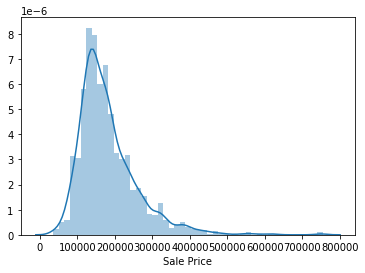

In [17]:
sns.distplot(df_concat['SalePrice'], axlabel='Sale Price')

In [18]:
print("歪度(Skewness) :", df_concat['SalePrice'].skew())
print("尖度(Kurtosis) :", df_concat['SalePrice'].kurt())

歪度(Skewness) : 1.8828757597682129
尖度(Kurtosis) : 6.536281860064529


In [19]:
df_concat['SalePrice_Log'] = df_concat['SalePrice'].apply(np.log)
df_concat['SalePrice_Log'].head()

0    12.247694
1    12.109011
2    12.317167
3    11.849398
4    12.429216
Name: SalePrice_Log, dtype: float64

<AxesSubplot:xlabel='Sale Price Log'>

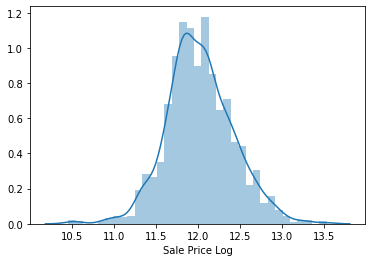

In [20]:
sns.distplot(df_concat['SalePrice_Log'], axlabel='Sale Price Log')

In [21]:
print("歪度(Skewness) :", df_concat['SalePrice_Log'].skew())
print("尖度(Kurtosis) :", df_concat['SalePrice_Log'].kurt())

歪度(Skewness) : 0.12133506220520406
尖度(Kurtosis) : 0.8095319958036296


2. GrLivArea

<AxesSubplot:xlabel='GrLivArea'>

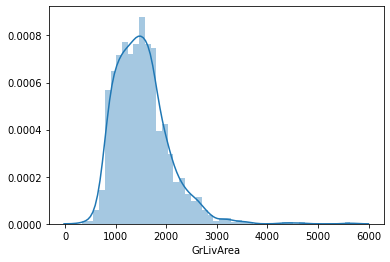

In [22]:
sns.distplot(df_concat['GrLivArea'])

In [23]:
print("歪度(Skewness) :", df_concat['GrLivArea'].skew())
print("尖度(Kurtosis) :", df_concat['GrLivArea'].kurt())

歪度(Skewness) : 1.3665603560164552
尖度(Kurtosis) : 4.895120580693174


In [24]:
df_concat['GrLivArea_Log'] = df_concat['GrLivArea'].apply(np.log)
df_concat['GrLivArea_Log'].head()

0    7.444249
1    7.140453
2    7.487734
3    7.448334
4    7.695303
Name: GrLivArea_Log, dtype: float64

<AxesSubplot:xlabel='GrLivArea Log'>

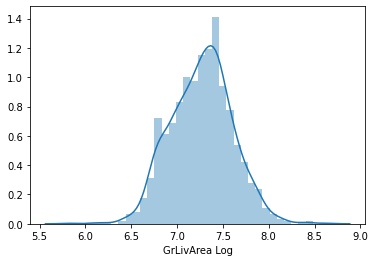

In [25]:
sns.distplot(df_concat['GrLivArea_Log'], axlabel='GrLivArea Log')

In [26]:
print("歪度(Skewness) :", df_concat['GrLivArea_Log'].skew())
print("尖度(Kurtosis) :", df_concat['GrLivArea_Log'].kurt())

歪度(Skewness) : -0.006995182187690808
尖度(Kurtosis) : 0.28260268850118564


3. YearBuilt

<AxesSubplot:xlabel='YearBuilt'>

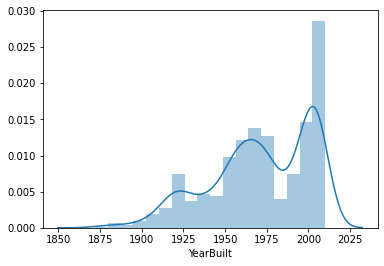

In [27]:
sns.distplot(df_concat['YearBuilt'])

時系データで対数変換無し\
2000年以降のデータが全体の約28%を構成

- 相関性の確認

In [28]:
corr_columns = ['GrLivArea_Log', 'YearBuilt', 'SalePrice_Log']
df_corr = pd.DataFrame(df_concat, columns=corr_columns)

In [29]:
corr_matrix = df_corr.corr()

<AxesSubplot:>

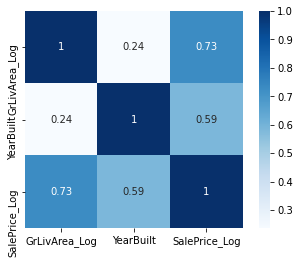

In [30]:
sns.heatmap(corr_matrix, annot=True, square=True, cmap="Blues")

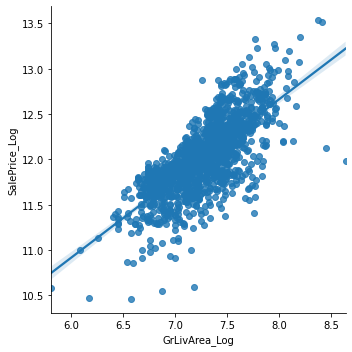

In [31]:
sns.lmplot(x='GrLivArea_Log',y='SalePrice_Log',data=df_concat)

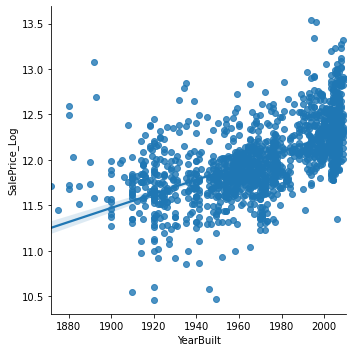

In [32]:
sns.lmplot(x='YearBuilt',y='SalePrice_Log',data=df_concat)

- 前処理・訓練データと検証データの分割

In [33]:
x_columns = ['GrLivArea_Log', 'YearBuilt']
y_column = ['SalePrice_Log']

df = df_corr.to_numpy()
X = df_corr[x_columns].to_numpy()
y = df_corr[y_column].to_numpy()

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70)

- 前処理・標準化

In [35]:
scaler = StandardScaler()

In [36]:
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [37]:
X_train_scaled = scaler.transform(X_train)

In [38]:
X_test_scaled = scaler.transform(X_test)

- 線形回帰による学習、推定、評価、可視化

In [39]:
lr_model = ScratchLinearRegression(num_iter=1000, lr=0.005, no_bias=False, verbose=True)
lr_model.fit(X_train_scaled, y_train.ravel(), X_test_scaled, y_test.ravel())
lr_pred = lr_model.predict(X_test_scaled)

Training Data****************************************
theta:[[0.15258972 0.60736269 0.5612334 ]]
loss in cost function:70.61708999243635
Validation Data****************************************
theta:[[0.15258972 0.60736269 0.5612334 ]]
loss in cost function:70.9548809139006
Training Data****************************************
theta:[[0.21192703 0.60507335 0.55886554]]
loss in cost function:69.91250411976455
Validation Data****************************************
theta:[[0.21192703 0.60507335 0.55886554]]
loss in cost function:70.24776493387957
Training Data****************************************
theta:[[0.27096767 0.60279822 0.5565122 ]]
loss in cost function:69.21495152469612
Validation Data****************************************
theta:[[0.27096767 0.60279822 0.5565122 ]]
loss in cost function:69.54770430388416
Training Data****************************************
theta:[[0.32971309 0.60053723 0.55417329]]
loss in cost function:68.52436198835007
Validation Data*********************

Training Data****************************************
theta:[[6.16659815 0.39194436 0.33724816]]
loss in cost function:17.185092218188515
Validation Data****************************************
theta:[[6.16659815 0.39194436 0.33724816]]
loss in cost function:17.312514353357226
Training Data****************************************
theta:[[6.19586543 0.39099435 0.33625244]]
loss in cost function:17.013828197608206
Validation Data****************************************
theta:[[6.19586543 0.39099435 0.33625244]]
loss in cost function:17.14044143391185
Training Data****************************************
theta:[[6.22498637 0.39005026 0.33526281]]
loss in cost function:16.84427341398277
Validation Data****************************************
theta:[[6.22498637 0.39005026 0.33526281]]
loss in cost function:16.970083718013274
Training Data****************************************
theta:[[6.2539617  0.38911205 0.33427924]]
loss in cost function:16.676410806864478
Validation Data***************

Training Data****************************************
theta:[[8.66442182 0.31566614 0.25683009]]
loss in cost function:5.660826519519287
Validation Data****************************************
theta:[[8.66442182 0.31566614 0.25683009]]
loss in cost function:5.725908533428998
Training Data****************************************
theta:[[8.68119997 0.31519168 0.25632578]]
loss in cost function:5.604570366962709
Validation Data****************************************
theta:[[8.68119997 0.31519168 0.25632578]]
loss in cost function:5.669277308696006
Training Data****************************************
theta:[[8.69789424 0.31472018 0.25582453]]
loss in cost function:5.54887559171028
Validation Data****************************************
theta:[[8.69789424 0.31472018 0.25582453]]
loss in cost function:5.613209882333879
Training Data****************************************
theta:[[8.71450503 0.31425163 0.25532635]]
loss in cost function:5.493736591288789
Validation Data*********************

Training Data****************************************
theta:[[10.04753598  0.27881059  0.21736901]]
loss in cost function:1.9704283621605705
Validation Data****************************************
theta:[[10.04753598  0.27881059  0.21736901]]
loss in cost function:2.006361325816835
Training Data****************************************
theta:[[10.05739857  0.27856661  0.21710515]]
loss in cost function:1.9509971253400649
Validation Data****************************************
theta:[[10.05739857  0.27856661  0.21710515]]
loss in cost function:1.9867344776819702
Training Data****************************************
theta:[[10.06721184  0.27832416  0.21684289]]
loss in cost function:1.9317597748842417
Validation Data****************************************
theta:[[10.06721184  0.27832416  0.21684289]]
loss in cost function:1.967302655806468
Training Data****************************************
theta:[[10.07697605  0.27808323  0.21658223]]
loss in cost function:1.9127143760407084
Validatio

Training Data****************************************
theta:[[10.79483492  0.26130932  0.19828184]]
loss in cost function:0.7741484139777512
Validation Data****************************************
theta:[[10.79483492  0.26130932  0.19828184]]
loss in cost function:0.7957022117406212
Training Data****************************************
theta:[[10.80096101  0.26117519  0.1981339 ]]
loss in cost function:0.7666534283476613
Validation Data****************************************
theta:[[10.80096101  0.26117519  0.1981339 ]]
loss in cost function:0.7880928711131553
Training Data****************************************
theta:[[10.80705648  0.26104191  0.19798686]]
loss in cost function:0.7592332236235536
Validation Data****************************************
theta:[[10.80705648  0.26104191  0.19798686]]
loss in cost function:0.780558936503111
Training Data****************************************
theta:[[10.81312146  0.26090946  0.19784071]]
loss in cost function:0.751887053638997
Validatio

Training Data****************************************
theta:[[11.4365686   0.24837943  0.18378956]]
loss in cost function:0.1932524581293793
Validation Data****************************************
theta:[[11.4365686   0.24837943  0.18378956]]
loss in cost function:0.2030975250299215
Training Data****************************************
theta:[[11.43948602  0.24832692  0.18372922]]
loss in cost function:0.1915531665437037
Validation Data****************************************
theta:[[11.43948602  0.24832692  0.18372922]]
loss in cost function:0.20134612746394773
Training Data****************************************
theta:[[11.44238886  0.24827475  0.18366925]]
loss in cost function:0.1898708283333959
Validation Data****************************************
theta:[[11.44238886  0.24827475  0.18366925]]
loss in cost function:0.19961195248517788
Training Data****************************************
theta:[[11.44527718  0.2482229   0.18360964]]
loss in cost function:0.18820527435227555
Vali

loss in cost function:0.07358597237785165
Training Data****************************************
theta:[[11.71897728  0.24368094  0.17827889]]
loss in cost function:0.06826510357332961
Validation Data****************************************
theta:[[11.71897728  0.24368094  0.17827889]]
loss in cost function:0.07310240055075802
Training Data****************************************
theta:[[11.72048266  0.24365837  0.17825161]]
loss in cost function:0.0678127530425487
Validation Data****************************************
theta:[[11.72048266  0.24365837  0.17825161]]
loss in cost function:0.07262352163869486
Training Data****************************************
theta:[[11.72198051  0.24363595  0.17822449]]
loss in cost function:0.0673649152799197
Validation Data****************************************
theta:[[11.72198051  0.24363595  0.17822449]]
loss in cost function:0.07214928947074357
Training Data****************************************
theta:[[11.72347088  0.24361368  0.17819753]]
lo

Training Data****************************************
theta:[[11.84395877  0.24193208  0.1761153 ]]
loss in cost function:0.03843142439290188
Validation Data****************************************
theta:[[11.84395877  0.24193208  0.1761153 ]]
loss in cost function:0.04106989210264292
Training Data****************************************
theta:[[11.84483924  0.24192079  0.17610088]]
loss in cost function:0.038276698846998074
Validation Data****************************************
theta:[[11.84483924  0.24192079  0.17610088]]
loss in cost function:0.04089969405905213
Training Data****************************************
theta:[[11.84571531  0.24190958  0.17608655]]
loss in cost function:0.03812351683950183
Validation Data****************************************
theta:[[11.84571531  0.24190958  0.17608655]]
loss in cost function:0.04073111701905504
Training Data****************************************
theta:[[11.846587    0.24189843  0.17607231]]
loss in cost function:0.03797186297174809

Training Data****************************************
theta:[[11.90505066  0.2411937   0.17514956]]
loss in cost function:0.029536043859154065
Validation Data****************************************
theta:[[11.90505066  0.2411937   0.17514956]]
loss in cost function:0.031100952407033408
Training Data****************************************
theta:[[11.90562568  0.24118724  0.17514084]]
loss in cost function:0.029470057704370466
Validation Data****************************************
theta:[[11.90562568  0.24118724  0.17514084]]
loss in cost function:0.03102485889136981
Training Data****************************************
theta:[[11.90619782  0.24118081  0.17513216]]
loss in cost function:0.02940472981383984
Validation Data****************************************
theta:[[11.90619782  0.24118081  0.17513216]]
loss in cost function:0.030949474062612083
Training Data****************************************
theta:[[11.90676709  0.24117443  0.17512354]]
loss in cost function:0.02934005362072

In [40]:
print("Mean Squared Error: {:.2f}".format(metrics.mean_squared_error(y_test, lr_pred)))

Mean Squared Error: 0.05


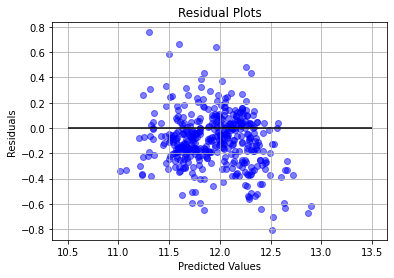

In [41]:
# テスト用データの残差プロット
plt.scatter(lr_pred, (lr_pred - y_test), c='b', alpha=0.5)

# y=0の水平線
plt.hlines(y=0,xmin=10.5,xmax=13.5, color='black')

plt.title('Residual Plots')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid()

plt.show()  

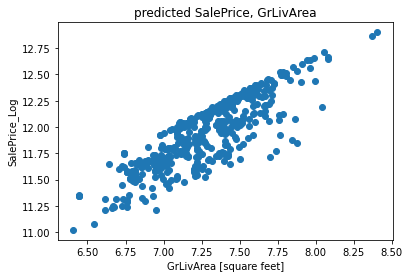

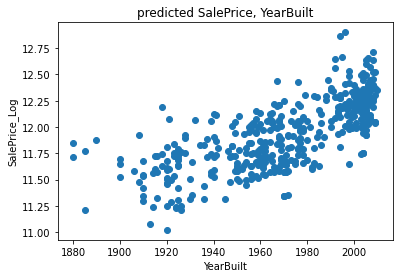

In [42]:
# 可視化
plt.title("predicted SalePrice, GrLivArea")
plt.xlabel("GrLivArea [square feet]")
plt.ylabel("SalePrice_Log")
plt.scatter(X_test[:, 0], lr_pred)
plt.show()

plt.title("predicted SalePrice, YearBuilt")
plt.xlabel("YearBuilt")
plt.ylabel("SalePrice_Log")
plt.scatter(X_test[:, 1], lr_pred)
plt.show()

- 学習率を調整する事によって、sklearnのSGDRegressorと同じようなスコアを得て、\
同じようなグラフをプロット可能である。

### 【問題7】学習曲線のプロット
学習曲線を表示する関数を作成し、実行してください。グラフを見て損失が適切に下がっているかどうか確認してください。


線形回帰クラスの雛形ではself.loss, self.val_lossに損失を記録しておくようになっているため、入力にはこれを利用してください。

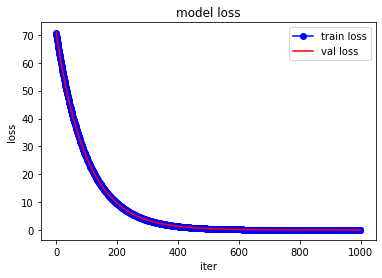

In [43]:
plt.figure()
plt.title("model loss")
plt.xlabel("iter")
plt.ylabel("loss")

x_plot = range(0, lr_model.iter)
plt.plot(x_plot, lr_model.loss, 'o-', color="b", label="train loss")
plt.plot(x_plot, lr_model.val_loss, '-', color="r", label="val loss")

plt.legend(loc="best")

plt.show()

### 【問題8】（アドバンス課題）バイアス項の除去
バイアス項 $\theta_0$ を抜くと学習がどう変化するか検証してください。また、線形回帰モデルにおけるバイアス項の役割の考察・調査を行ってください。

- 回答前の所感\
　バイアス項を抜くと、切片が考慮されなくなるため、グラフへのプロットが「0, 0」地点から開始される。\
　従って、プロットされる曲線に柔軟性がなくなり、誤差が大きくなるものと考えられる。


In [44]:
lr_model = ScratchLinearRegression(num_iter=1000, lr=0.005, no_bias=True, verbose=True)
lr_model.fit(X_train_scaled, y_train.ravel())
lr_pred = lr_model.predict(X_test_scaled)

Training Data****************************************
theta:[[0.97708304 0.57806866]]
loss in cost function:72.68678663275226
Training Data****************************************
theta:[[0.97292538 0.57518375]]
loss in cost function:72.68168048032526
Training Data****************************************
theta:[[0.96879189 0.57231813]]
loss in cost function:72.67663639835308
Training Data****************************************
theta:[[0.96468242 0.56947168]]
loss in cost function:72.67165362890698
Training Data****************************************
theta:[[0.96059683 0.56664427]]
loss in cost function:72.66673142333931
Training Data****************************************
theta:[[0.95653498 0.56383579]]
loss in cost function:72.66186904216981
Training Data****************************************
theta:[[0.95249673 0.5610461 ]]
loss in cost function:72.65706575497315
Training Data****************************************
theta:[[0.94848194 0.55827508]]
loss in cost function:72.6523208

Training Data****************************************
theta:[[0.45210004 0.24526744]]
loss in cost function:72.2923201920701
Training Data****************************************
theta:[[0.45095695 0.2446612 ]]
loss in cost function:72.2919863529369
Training Data****************************************
theta:[[0.44982028 0.24405932]]
loss in cost function:72.29165648717148
Training Data****************************************
theta:[[0.44869    0.24346179]]
loss in cost function:72.29133054691185
Training Data****************************************
theta:[[0.44756607 0.24286856]]
loss in cost function:72.29100848487703
Training Data****************************************
theta:[[0.44644846 0.24227962]]
loss in cost function:72.29069025436007
Training Data****************************************
theta:[[0.44533712 0.24169493]]
loss in cost function:72.29037580922086
Training Data****************************************
theta:[[0.44423203 0.24111447]]
loss in cost function:72.290065103

Training Data****************************************
theta:[[0.3178005  0.18353203]]
loss in cost function:72.26699676330789
Training Data****************************************
theta:[[0.31740119 0.1833917 ]]
loss in cost function:72.26696103741953
Training Data****************************************
theta:[[0.31700404 0.18325254]]
loss in cost function:72.26692571989138
Training Data****************************************
theta:[[0.31660904 0.18311454]]
loss in cost function:72.26689080593755
Training Data****************************************
theta:[[0.31621617 0.1829777 ]]
loss in cost function:72.26685629082932
Training Data****************************************
theta:[[0.31582543 0.182842  ]]
loss in cost function:72.26682216989425
Training Data****************************************
theta:[[0.3154368  0.18270743]]
loss in cost function:72.26678843851566
Training Data****************************************
theta:[[0.31505027 0.18257399]]
loss in cost function:72.2667550

Training Data****************************************
theta:[[0.26067583 0.16985222]]
loss in cost function:72.26395887618538
Training Data****************************************
theta:[[0.26057816 0.16984717]]
loss in cost function:72.26395696797978
Training Data****************************************
theta:[[0.26048098 0.16984227]]
loss in cost function:72.2639550792615
Training Data****************************************
theta:[[0.26038429 0.1698375 ]]
loss in cost function:72.26395320982131
Training Data****************************************
theta:[[0.2602881  0.16983287]]
loss in cost function:72.26395135945225
Training Data****************************************
theta:[[0.26019238 0.16982837]]
loss in cost function:72.2639495279497
Training Data****************************************
theta:[[0.26009716 0.16982401]]
loss in cost function:72.2639477151114
Training Data****************************************
theta:[[0.26000241 0.16981978]]
loss in cost function:72.2639459207

Training Data****************************************
theta:[[0.24775853 0.17052234]]
loss in cost function:72.2637888435512
Training Data****************************************
theta:[[0.24772466 0.17052906]]
loss in cost function:72.26378860559082
Training Data****************************************
theta:[[0.24769095 0.1705358 ]]
loss in cost function:72.26378836979163
Training Data****************************************
theta:[[0.2476574  0.17054254]]
loss in cost function:72.26378813613289
Training Data****************************************
theta:[[0.24762401 0.17054928]]
loss in cost function:72.26378790459405
Training Data****************************************
theta:[[0.24759078 0.17055603]]
loss in cost function:72.26378767515486
Training Data****************************************
theta:[[0.24755771 0.17056279]]
loss in cost function:72.26378744779518
Training Data****************************************
theta:[[0.24752479 0.17056955]]
loss in cost function:72.26378722

In [45]:
print("Mean Squared Error: {:.2f}".format(metrics.mean_squared_error(y_test, lr_pred)))

Mean Squared Error: 144.96


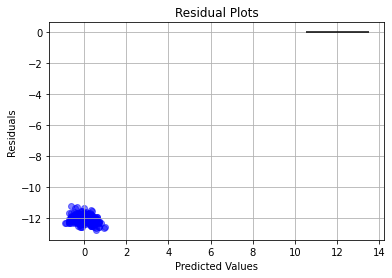

In [46]:
# テスト用データの残差プロット
plt.scatter(lr_pred, (lr_pred - y_test), c='b', alpha=0.5)

# y=0の水平線
plt.hlines(y=0,xmin=10.5,xmax=13.5, color='black')

plt.title('Residual Plots')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid()

plt.show()  

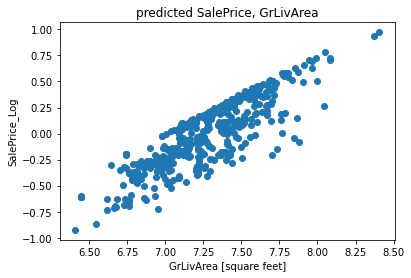

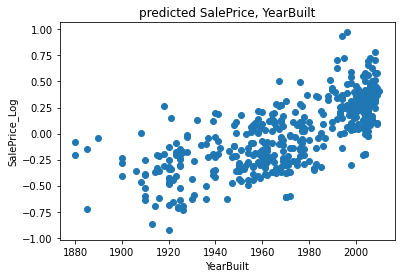

In [47]:
# 可視化
plt.title("predicted SalePrice, GrLivArea")
plt.xlabel("GrLivArea [square feet]")
plt.ylabel("SalePrice_Log")
plt.scatter(X_test[:, 0], lr_pred)
plt.show()

plt.title("predicted SalePrice, YearBuilt")
plt.xlabel("YearBuilt")
plt.ylabel("SalePrice_Log")
plt.scatter(X_test[:, 1], lr_pred)
plt.show()

- コスト関数の実行を繰り返しても残差は余り減少しない。
- MSEのスコアは切片ありのものと比較しても非常に悪い結果となっている。

### 【問題9】（アドバンス課題）特徴量の多次元化
特徴量の二乗や三乗を入力に利用すると学習結果がどう変化するか検証してください。

In [48]:
x_columns = ['GrLivArea', 'YearBuilt']
y_column = ['SalePrice']

X_two_columns = pd.DataFrame(df_train, columns=x_columns)
y_saleprice = pd.DataFrame(df_train, columns=y_column)

df_concat = pd.concat([X_two_columns, y_saleprice], axis=1)

In [49]:
df_concat.head()

,GrLivArea,YearBuilt,SalePrice
0,1710,2003,208500
1,1262,1976,181500
2,1786,2001,223500
3,1717,1915,140000
4,2198,2000,250000


In [50]:
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 3 columns):
GrLivArea    1460 non-null int64
YearBuilt    1460 non-null int64
SalePrice    1460 non-null int64
dtypes: int64(3)
memory usage: 34.3 KB


- 分布の確認

   1. SalePrice

<AxesSubplot:xlabel='Sale Price'>

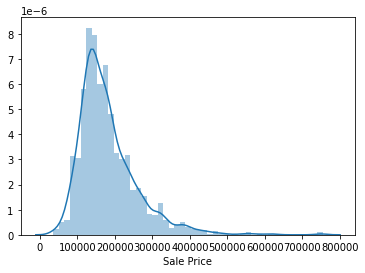

In [51]:
sns.distplot(df_concat['SalePrice'], axlabel='Sale Price')

In [52]:
print("歪度(Skewness) :", df_concat['SalePrice'].skew())
print("尖度(Kurtosis) :", df_concat['SalePrice'].kurt())

歪度(Skewness) : 1.8828757597682129
尖度(Kurtosis) : 6.536281860064529


In [53]:
df_concat['SalePrice_Log'] = df_concat['SalePrice'].apply(np.log)
df_concat['SalePrice_Log'].head()

0    12.247694
1    12.109011
2    12.317167
3    11.849398
4    12.429216
Name: SalePrice_Log, dtype: float64

<AxesSubplot:xlabel='Sale Price Log'>

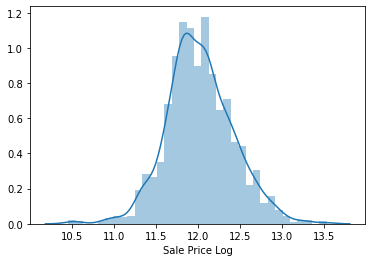

In [54]:
sns.distplot(df_concat['SalePrice_Log'], axlabel='Sale Price Log')

In [55]:
print("歪度(Skewness) :", df_concat['SalePrice_Log'].skew())
print("尖度(Kurtosis) :", df_concat['SalePrice_Log'].kurt())

歪度(Skewness) : 0.12133506220520406
尖度(Kurtosis) : 0.8095319958036296


2. GrLivArea

<AxesSubplot:xlabel='GrLivArea'>

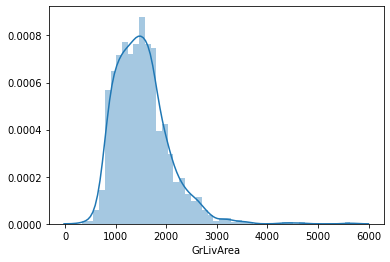

In [56]:
sns.distplot(df_concat['GrLivArea'])

In [57]:
print("歪度(Skewness) :", df_concat['GrLivArea'].skew())
print("尖度(Kurtosis) :", df_concat['GrLivArea'].kurt())

歪度(Skewness) : 1.3665603560164552
尖度(Kurtosis) : 4.895120580693174


In [58]:
df_concat['GrLivArea_Log'] = df_concat['GrLivArea'].apply(np.log)
df_concat['GrLivArea_Log'].head()

0    7.444249
1    7.140453
2    7.487734
3    7.448334
4    7.695303
Name: GrLivArea_Log, dtype: float64

<AxesSubplot:xlabel='GrLivArea Log'>

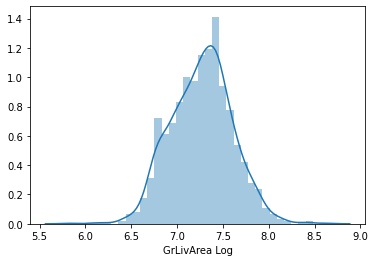

In [59]:
sns.distplot(df_concat['GrLivArea_Log'], axlabel='GrLivArea Log')

In [60]:
print("歪度(Skewness) :", df_concat['GrLivArea_Log'].skew())
print("尖度(Kurtosis) :", df_concat['GrLivArea_Log'].kurt())

歪度(Skewness) : -0.006995182187690808
尖度(Kurtosis) : 0.28260268850118564


3. YearBuilt

<AxesSubplot:xlabel='YearBuilt'>

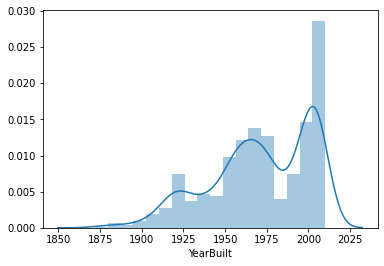

In [61]:
sns.distplot(df_concat['YearBuilt'])

- __多項式特徴量の適用__\
'GrLivArea_Log'に対して適用\
'YearBuilt'は時系データで適用無し

In [62]:
poly_cols = ['GrLivArea_Log']
df_poly_features = df_concat[poly_cols]

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

# Train the polynomial features
poly_transformer.fit(df_poly_features)

# Transform the features
poly_features = poly_transformer.transform(df_poly_features)

# Get the polynomial feature names
poly_features = pd.DataFrame(poly_features,
                             columns=poly_transformer.get_feature_names(poly_cols))

In [63]:
poly_transformer.get_feature_names(input_features = poly_cols)

['1', 'GrLivArea_Log', 'GrLivArea_Log^2', 'GrLivArea_Log^3']

In [64]:
df_concat = pd.concat([df_concat, poly_features.iloc[:, 2:]], axis=1)

In [65]:
df_concat

,GrLivArea,YearBuilt,SalePrice,SalePrice_Log,GrLivArea_Log,GrLivArea_Log^2,GrLivArea_Log^3
0,1710,2003,208500,12.247694,7.444249,55.416838,412.536721
1,1262,1976,181500,12.109011,7.140453,50.986070,364.063636
2,1786,2001,223500,12.317167,7.487734,56.066157,419.808456
3,1717,1915,140000,11.849398,7.448334,55.477677,413.216262
4,2198,2000,250000,12.429216,7.695303,59.217690,455.698078
...,...,...,...,...,...,...,...
1455,1647,1999,175000,12.072541,7.406711,54.859364,406.327439
1456,2073,1978,210000,12.254863,7.636752,58.319983,445.375252
1457,2340,1941,266500,12.493130,7.757906,60.185109,466.910429
1458,1078,1950,142125,11.864462,6.982863,48.760372,340.486987


- 相関性の確認

In [66]:
corr_columns = ['GrLivArea_Log', 'GrLivArea_Log^2', 'GrLivArea_Log^3', 'YearBuilt', 'SalePrice_Log']
df_corr = pd.DataFrame(df_concat, columns=corr_columns)

In [67]:
corr_matrix = df_corr.corr()

<AxesSubplot:>

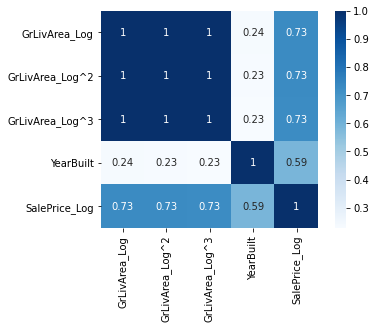

In [68]:
sns.heatmap(corr_matrix, annot=True, square=True, cmap="Blues")

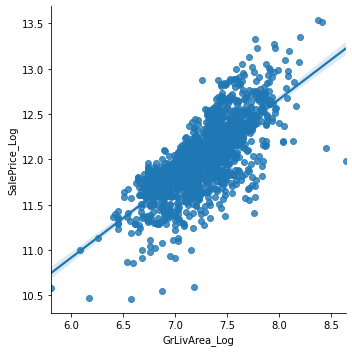

In [69]:
sns.lmplot(x='GrLivArea_Log',y='SalePrice_Log',data=df_corr)

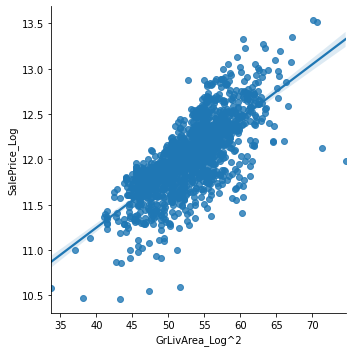

In [70]:
sns.lmplot(x='GrLivArea_Log^2',y='SalePrice_Log',data=df_corr)

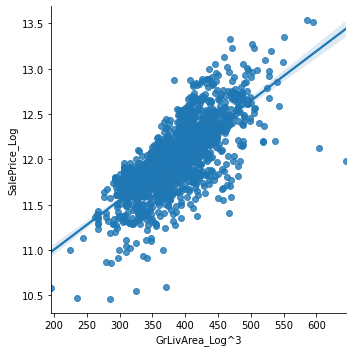

In [71]:
sns.lmplot(x='GrLivArea_Log^3',y='SalePrice_Log',data=df_corr)

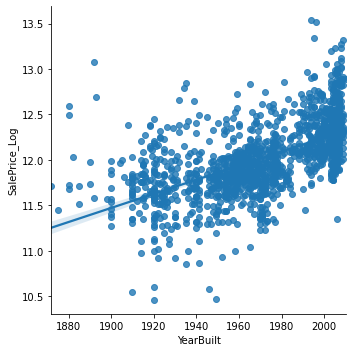

In [72]:
sns.lmplot(x='YearBuilt',y='SalePrice_Log',data=df_corr)

- 前処理・訓練データと検証データの分割

In [73]:
x_columns = ['GrLivArea_Log', 'GrLivArea_Log^2','GrLivArea_Log^3', 'YearBuilt']
y_column = ['SalePrice_Log']

df = df_corr.to_numpy()
X = df_corr[x_columns].to_numpy()
y = df_corr[y_column].to_numpy()

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70)

- 前処理・標準化

In [75]:
scaler = StandardScaler()

In [76]:
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [77]:
X_train_scaled = scaler.transform(X_train)

In [78]:
X_test_scaled = scaler.transform(X_test)

- 線形回帰による学習、推定、評価、可視化

In [79]:
lr_model = ScratchLinearRegression(num_iter=1000, lr=0.005, no_bias=False, verbose=True)
lr_model.fit(X_train_scaled, y_train.ravel())
lr_pred = lr_model.predict(X_test_scaled)

Training Data****************************************
theta:[[0.91976611 0.94141874 0.84523163 0.38602339 0.97817518]]
loss in cost function:64.1282109963408
Training Data****************************************
theta:[[0.97526076 0.93091012 0.83473772 0.37555703 0.97200941]]
loss in cost function:63.440753524270946
Training Data****************************************
theta:[[1.03047794 0.92056566 0.82440794 0.36525456 0.96590939]]
loss in cost function:62.76161797787639
Training Data****************************************
theta:[[1.08541903 0.91038281 0.81423976 0.35511347 0.95987423]]
loss in cost function:62.09067672115429
Training Data****************************************
theta:[[1.14008541 0.9003591  0.80423068 0.34513126 0.95390308]]
loss in cost function:61.42780475051921
Training Data****************************************
theta:[[1.19447846 0.89049206 0.79437824 0.33530548 0.94799508]]
loss in cost function:60.7728796271473
Training Data**********************************

Training Data****************************************
theta:[[ 8.65222915  0.29545346  0.20196346 -0.25373433  0.36877556]]
loss in cost function:5.708816921768155
Training Data****************************************
theta:[[ 8.66906149  0.2952687   0.20178718 -0.25390182  0.36779694]]
loss in cost function:5.652083636913459
Training Data****************************************
theta:[[ 8.68580966  0.29508768  0.20161462 -0.25406561  0.3668238 ]]
loss in cost function:5.595917081642393
Training Data****************************************
theta:[[ 8.70247409  0.29491034  0.20144572 -0.25422575  0.3658561 ]]
loss in cost function:5.540311575535196
Training Data****************************************
theta:[[ 8.7190552   0.29473663  0.20128044 -0.25438231  0.3648938 ]]
loss in cost function:5.48526149568832
Training Data****************************************
theta:[[ 8.7355534   0.29456648  0.20111869 -0.25453535  0.36393686]]
loss in cost function:5.430761276114496
Training Data****

Training Data****************************************
theta:[[10.51662531  0.28887791  0.19657016 -0.25792734  0.26234563]]
loss in cost function:1.1551483131913243
Training Data****************************************
theta:[[10.52413567  0.2888941   0.19659279 -0.25789825  0.26191714]]
loss in cost function:1.14385847956195
Training Data****************************************
theta:[[10.53160847  0.28891044  0.19661556 -0.25786904  0.26149072]]
loss in cost function:1.132681242334045
Training Data****************************************
theta:[[10.5390439   0.28892692  0.19663846 -0.2578397   0.26106635]]
loss in cost function:1.1216154784043817
Training Data****************************************
theta:[[10.54644216  0.28894354  0.19666148 -0.25781024  0.26064403]]
loss in cost function:1.1106600758764011
Training Data****************************************
theta:[[10.55380343  0.28896029  0.19668463 -0.25778067  0.26022375]]
loss in cost function:1.0998139339482562
Training Data

Training Data****************************************
theta:[[11.58319271  0.29268515  0.20178072 -0.2513138   0.19990495]]
loss in cost function:0.1183021020023831
Training Data****************************************
theta:[[11.58537022  0.29269381  0.20179454 -0.25129483  0.19977138]]
loss in cost function:0.1173524731566571
Training Data****************************************
theta:[[11.58753685  0.29270241  0.20180829 -0.25127593  0.19963843]]
loss in cost function:0.11641231416849321
Training Data****************************************
theta:[[11.58969265  0.29271096  0.20182199 -0.25125709  0.1995061 ]]
loss in cost function:0.1154815306001542
Training Data****************************************
theta:[[11.59183766  0.29271945  0.20183563 -0.25123831  0.19937438]]
loss in cost function:0.11456002895569953
Training Data****************************************
theta:[[11.59397195  0.29272789  0.20184922 -0.25121958  0.19924328]]
loss in cost function:0.11364771667159093
Trainin

Training Data****************************************
theta:[[11.85888455  0.29353201  0.20361703 -0.24848971  0.18249258]]
loss in cost function:0.035903645148234735
Training Data****************************************
theta:[[11.8596836   0.29353284  0.20362265 -0.2484793   0.18244   ]]
loss in cost function:0.03577568650979851
Training Data****************************************
theta:[[11.86047866  0.29353365  0.20362824 -0.24846893  0.18238767]]
loss in cost function:0.03564900377055078
Training Data****************************************
theta:[[11.86126975  0.29353443  0.20363381 -0.24845858  0.18233557]]
loss in cost function:0.03552358420715807
Training Data****************************************
theta:[[11.86205688  0.29353518  0.20363935 -0.24844826  0.18228373]]
loss in cost function:0.035399415223166794
Training Data****************************************
theta:[[11.86284007  0.29353591  0.20364487 -0.24843797  0.18223212]]
loss in cost function:0.035276484347738474
T

In [80]:
print("Mean Squared Error: {:.2f}".format(metrics.mean_squared_error(y_test, lr_pred)))

Mean Squared Error: 0.05


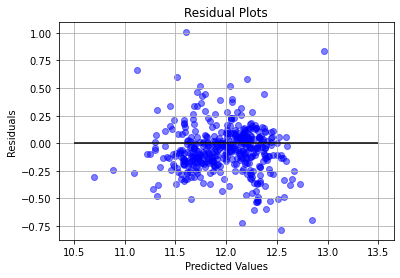

In [81]:
# テスト用データの残差プロット
plt.scatter(lr_pred, (lr_pred - y_test), c='b', alpha=0.5)

# y=0の水平線
plt.hlines(y=0,xmin=10.5,xmax=13.5, color='black')

plt.title('Residual Plots')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid()

plt.show()  

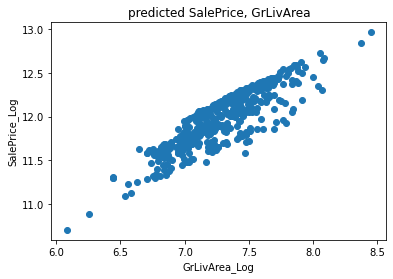

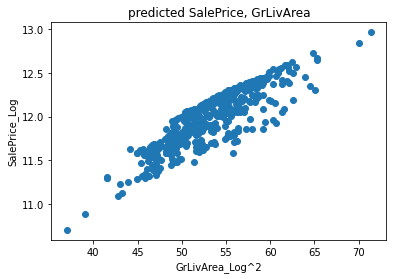

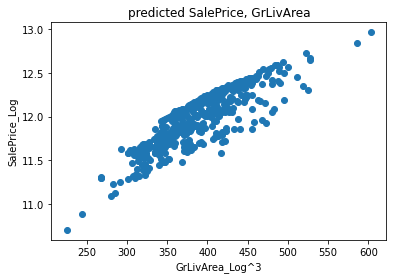

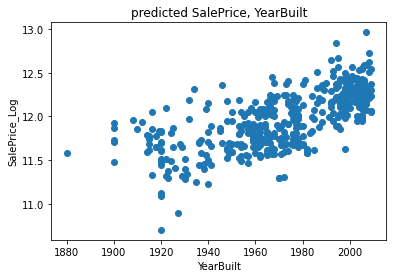

In [82]:
# 可視化
plt.title("predicted SalePrice, GrLivArea")
plt.xlabel("GrLivArea_Log")
plt.ylabel("SalePrice_Log")
plt.scatter(X_test[:, 0], lr_pred)
plt.show()

plt.title("predicted SalePrice, GrLivArea")
plt.xlabel("GrLivArea_Log^2")
plt.ylabel("SalePrice_Log")
plt.scatter(X_test[:, 1], lr_pred)
plt.show()

plt.title("predicted SalePrice, GrLivArea")
plt.xlabel("GrLivArea_Log^3")
plt.ylabel("SalePrice_Log")
plt.scatter(X_test[:, 2], lr_pred)
plt.show()

plt.title("predicted SalePrice, YearBuilt")
plt.xlabel("YearBuilt")
plt.ylabel("SalePrice_Log")
plt.scatter(X_test[:, 3], lr_pred)
plt.show()

線形回帰は、特徴量と目的変数間に直線的な関係があると上手く適合する。
特徴量を２乗・３乗する事によって曲線を描くと、線形モデルでは対応が難しくなると思ったが変わらないスコアになっている。
理解が追い付いていない部分があり、今後も検証が必要である。

### 【問題10】（アドバンス課題）更新式の導出
最急降下法の更新式は以下でした。この式が導出される過程を説明してください。


$$
\theta_{j}:=\theta_{j}-α\frac{1}{m}\displaystyle \sum_{i=1}^m
[(h_{\theta}(x^{(i)})-y^{(i)})x_{j}^{(i)}]
$$

以下の式から説明をはじめることができます。


$$
\theta_{j}:=\theta_{j}-\frac{\delta}{\delta\theta_{j}}J(\theta)
$$

目的関数（損失関数） $J(\theta)$ は次の式です。


$$
J(\theta)=\frac{1}{2m}\displaystyle \sum_{i=1}^m
(h_{\theta}(x^{(i)})-y^{(i)})^2.
$$

- 説明

$$
\theta_{j}:=\theta_{j}-\frac{\delta}{\delta\theta_{j}}J(\theta)
$$

上記の式は、各回帰係数(theta)の値を更新している。\
 $J(\theta_{0},\theta_{1}...)$ が誤差の2乗の合計になり、これを出来るだけ小さくなるように $J(\theta_{0},\theta_{1}...)$ を調整する。

$$
J(\theta_{0},\theta_{1}...\theta_{j})=\frac{1}{2m}\displaystyle \sum_{i=1}^m
(h_{\theta}(x^{(i)})-y^{(i)})^2.
$$

調整するにあたり、最急降下法で目的関数を微分する事によって傾きを求める。\
下記の式の部分は、感覚的につかみ辛いが、微分した値(傾き)の合計値を求めている。\
偏微分により、各回帰係数の方向をとらえる。

$$
\displaystyle \sum_{i=1}^m[(h_{\theta}(x^{(i)})-y^{(i)})x_{j}^{(i)}]
$$

上記式を仮に下記の式のように各回帰係数から引いて更新値を求めるとどうなるだろうか。
$$
\theta_{j}:=\theta_{j}-\frac{1}{m}\displaystyle \sum_{i=1}^m
[(h_{\theta}(x^{(i)})-y^{(i)})x_{j}^{(i)}]
$$

上記式では、各回帰係数(theta)に与える影響が大きくなるため、最適解にたどり着くのに時間を要する(勾配を行き過ぎたりする)。\
そこで、学習率αを用いて更新を行う。学習率αを乗じる事によって、徐々に坂を降るイメージとなる。
$$
\theta_{j}:=\theta_{j}-α\frac{1}{m}\displaystyle \sum_{i=1}^m
[(h_{\theta}(x^{(i)})-y^{(i)})x_{j}^{(i)}]
$$

### 【問題11】（アドバンス課題）局所最適解の問題
最急降下法には一般的に局所最適解の問題があります。しかし、線形回帰では学習を続ければ必ず最適解を求めることができます。それはなぜか数式やグラフを用いて説明してください。

線形モデル・最小二乗法にて調査

__他受講生の回答など参考になるものがあれば情報の共有をお願いします。__